<a href="https://colab.research.google.com/github/williambiondi/RecommenderGS/blob/main/recommenderGranSasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importazione dei dati e librerie


In [1]:
!pip install tensorflow -q
!pip install transformers -q
!pip install tensorflow-recommenders -q

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from transformers import DistilBertTokenizer, TFDistilBertModel
from IPython import display
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import re

#Caricamento dati

In [3]:
items = pd.read_csv('ArticoliGransasso.csv')
customers = pd.read_csv('ClientiGransasso.csv')
purchases = pd.read_csv('OrdiniGransasso.csv')

items.drop(columns=['Unnamed: 0'], inplace=True)
customers.drop(columns=['Unnamed: 0'], inplace=True)
purchases.drop(columns=['Unnamed: 0'], inplace=True)

#Preparazione dati per modello


ricavo le fasce di prezzo

In [4]:
bins = list(range(0, int(items['UnitPrice'].max()) + 150, 150))
items['PriceRange'] = pd.cut(items['UnitPrice'], bins = bins, right=False).astype(str)

Annoto come interazione positiva (1) tutti gli articoli acquistati, come interazione negativa (-1) tutti gli articoli rimborsati

In [5]:
interactions = [1 if row['RefundedEUR'] == 0 else -1 for _,row in purchases.iterrows()]
purchases["Interaction"] = interactions

In [6]:
text_combined = []
for idx, row in items.iterrows():
  descriptive = row['ItemName'].lower()+" "+row['Description']
  text_combined.append(descriptive)
items['TextInfo'] = text_combined

In [11]:
len_desc = [len(row['TextInfo'].split(" ")) for _,row in items.iterrows()]
max(len_desc)

190

Utilizzo DistilBERT per ottenere gli embeddings di tutta l'informazione testuale degli articoli (nome articolo e descrizione)

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
enc_input = tokenizer(items['TextInfo'].tolist(),
                      padding=True,
                      truncation=True,
                      max_length=150,
                      return_tensors='tf')

In [13]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [14]:
outputs = distilbert_model(enc_input)
embeddings = outputs.last_hidden_state

In [15]:
embeddings_np = embeddings.numpy()
summary_embeddings = embeddings_np[:,0,:]
df_embeddings = pd.DataFrame(summary_embeddings)
df_embeddings.columns = [f'embedding_{i}' for i in range(df_embeddings.shape[1])]

In [17]:
df_embeddings.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,-0.152692,-0.702594,0.226575,-0.092627,0.150878,-0.052346,0.132293,0.289687,-0.130670,-0.294651,...,-0.045851,-0.592887,0.098132,-0.310700,0.045292,-0.331142,-0.110403,-0.167462,0.064619,-0.084191
1,-0.183465,-0.758047,0.025607,-0.106878,0.167659,-0.116863,0.084983,0.325271,0.031011,-0.256441,...,-0.039702,-0.501641,0.018874,-0.313824,0.023122,-0.488100,-0.089355,-0.199527,0.250173,-0.131352
2,-0.235758,-0.616278,0.186698,-0.050992,0.163522,-0.045681,0.081499,0.254824,-0.088808,-0.285371,...,0.009386,-0.555698,0.095906,-0.385060,-0.018019,-0.202692,-0.129432,-0.250053,0.047502,-0.117530
3,-0.080283,-0.587356,0.281823,-0.119877,0.063588,-0.044179,0.075656,0.288735,-0.159558,-0.265397,...,0.126247,-0.505958,0.169416,-0.327713,0.025114,-0.154299,-0.163061,-0.110773,0.150633,0.053784
4,-0.136119,-0.455885,0.220127,-0.032341,0.044970,-0.166100,0.079893,0.324760,-0.202329,-0.267275,...,-0.074009,-0.526028,0.137117,-0.344637,-0.017099,-0.273234,-0.202651,-0.110191,0.116088,0.078281


Riduco gli embeddings

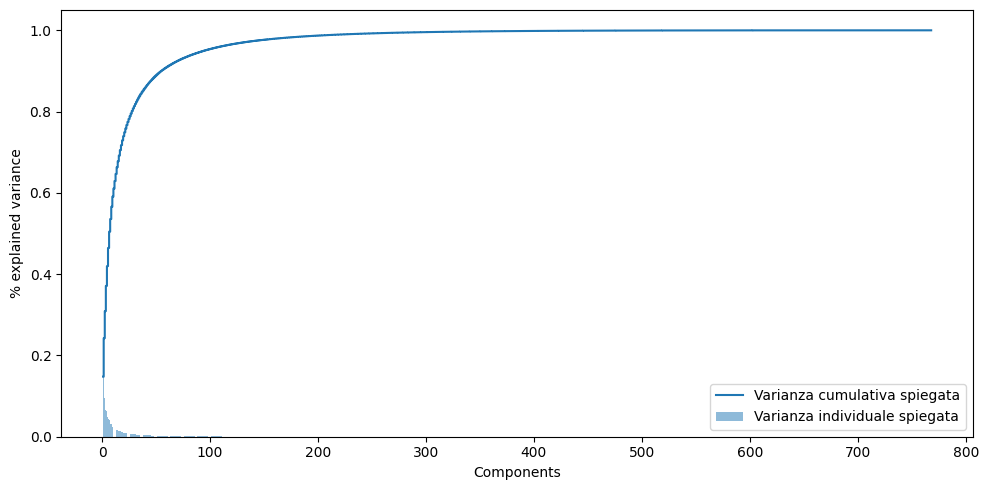

In [18]:
pca = PCA()
pca.fit(df_embeddings)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

n_components = np.where(cumulative>=0.95)[0][0]+1

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained) + 1), explained, alpha=0.5, align='center', label='Varianza individuale spiegata')
plt.step(range(1, len(cumulative) + 1), cumulative, where='mid', label='Varianza cumulativa spiegata')
plt.ylabel('% explained variance')
plt.xlabel('Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [19]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(df_embeddings)
df_reduced = pd.DataFrame(reduced, columns = [f"pc_{i}" for i in range(reduced.shape[1])])

In [20]:
df_reduced['ItemId'] = items['ItemId']

In [21]:
df_reduced.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_86,pc_87,pc_88,pc_89,pc_90,pc_91,pc_92,pc_93,pc_94,ItemId
0,0.432970,-0.214817,-0.676690,0.242795,-0.502648,0.213221,0.044403,-0.406393,0.119937,0.290788,...,0.075954,0.048401,0.052903,-0.014752,0.093254,-0.010880,0.016922,0.031552,0.073929,0
1,-1.344925,-0.502454,-0.108866,-0.200825,-0.811725,-0.145817,-0.138477,-0.102824,0.132496,-0.286611,...,-0.064398,-0.051269,-0.105513,0.010401,0.106022,0.085174,0.021827,0.130571,-0.105465,1
2,-0.508015,0.428695,-0.924207,-0.456854,-0.142498,-0.227777,0.160293,0.145646,-0.215663,-0.172413,...,-0.005664,-0.024329,0.049559,-0.111370,-0.079986,0.054225,0.012665,-0.090416,0.111051,2
3,0.467722,0.633643,-0.853464,0.216088,-0.056626,-0.370799,-0.207278,0.360085,0.606440,0.535529,...,0.135940,-0.064581,0.018557,0.069406,0.226960,0.191141,0.079250,0.232924,-0.020586,3
4,1.449939,0.353151,-0.104015,-0.192967,-0.214778,-0.368199,-0.541564,0.426432,0.140477,0.117264,...,0.113850,-0.062613,-0.042834,-0.021624,0.020678,-0.010432,0.124275,0.085975,0.030929,4


In [22]:
full_items = items.merge(df_reduced, on='ItemId')

In [23]:
df_full = full_items.merge(purchases, on='ItemId')

In [24]:
df_full.head()

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,...,pc_91,pc_92,pc_93,pc_94,Id,UserId,CreatedOnUtc,RefundedEUR,UnitPriceTaxEUR,Interaction
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.010880,0.016922,0.031552,0.073929,8812,0,2021-01-01 09:29:05.2513839,0.0,130.0,1
1,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.010880,0.016922,0.031552,0.073929,8860,47,2021-01-03 23:11:34.9635880,0.0,130.0,1
2,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.010880,0.016922,0.031552,0.073929,9311,413,2021-02-13 12:39:33.7391675,0.0,130.0,1
3,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.010880,0.016922,0.031552,0.073929,9772,276,2021-04-10 11:33:22.9952881,0.0,130.0,1
4,A20201312414230005,WAVE PATTERN TURTLENECK,['Maglieria'],160.0,1,Fall-Winter,0,5,Men,turtleneck sweater in pure merino wool embelli...,...,0.085174,0.021827,0.130571,-0.105465,8813,1,2021-01-01 09:39:57.3829465,0.0,160.0,1


#Training

In [25]:
data_tf = tf.data.Dataset.from_tensor_slices({
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "item_id": df_full['ItemId'].values.reshape(-1,1),
    "item_embedding" : df_full[[f'pc_{i}' for i in range(reduced.shape[1])]].values
})

In [26]:
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'pc_{i}' for i in range(reduced.shape[1])]].values
})
candidates_ds = candidates_tf.batch(32)

In [43]:
for features in train.take(1):
    print("User ID Shape in Train:", features["item_id"].shape)
    print("Item Embedding Shape in Train:", features["item_embedding"].shape)

User ID Shape in Train: (32, 1)
Item Embedding Shape in Train: (32, 95)


Divido in train e test

In [28]:
data_tf = data_tf.shuffle(buffer_size=1024)
train = data_tf.take(int(len(df_full) * 0.8))
test = data_tf.skip(int(len(df_full) * 0.8))

In [29]:
batch_size = 32
train = train.batch(batch_size)
test = test.batch(batch_size)

In [35]:
for features in train.take(1):
    print("User ID Shape in Train:", features["user_id"].shape)
    print("Item Embedding Shape in Train:", features["item_embedding"].shape)

User ID Shape in Train: (32, 1)
Item Embedding Shape in Train: (32, 95)


In [32]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))

  def compute_loss(self, features, training = False):
    user_emb = self.user_model(features['user_id'])
    item_emb = self.item_model(features['item_embedding'])
    return self.task(user_emb, item_emb)

In [36]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = n_components

user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  tf.keras.layers.Flatten()
                                  ])

item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  tf.keras.layers.Dense(embedding_dim)
                                ])

In [37]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.003))

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [38]:
recommender.fit(train, epochs=100)

Epoch 1/100
497/497 [==============================] - 41s 79ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 5.0324e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0010 - factorized_top_k/top_50_categorical_accuracy: 0.0206 - factorized_top_k/top_100_categorical_accuracy: 0.0435 - loss: 110.4520 - regularization_loss: 0.0000e+00 - total_loss: 110.4520
Epoch 2/100
497/497 [==============================] - 39s 78ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0018 - factorized_top_k/top_10_categorical_accuracy: 0.0054 - factorized_top_k/top_50_categorical_accuracy: 0.0671 - factorized_top_k/top_100_categorical_accuracy: 0.1235 - loss: 108.9404 - regularization_loss: 0.0000e+00 - total_loss: 108.9404
Epoch 3/100
497/497 [==============================] - 38s 77ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_ca

In [39]:
recommender.evaluate(test)

125/125 [==============================] - 10s 78ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0382 - factorized_top_k/top_5_categorical_accuracy: 0.0727 - factorized_top_k/top_10_categorical_accuracy: 0.0921 - factorized_top_k/top_50_categorical_accuracy: 0.1728 - factorized_top_k/top_100_categorical_accuracy: 0.2176 - loss: 100.4262 - regularization_loss: 0.0000e+00 - total_loss: 100.4262


[0.038238994777202606,
 0.07270440459251404,
 0.09207547456026077,
 0.17283019423484802,
 0.21761006116867065,
 11.256402015686035,
 0,
 11.256402015686035]

#Raccomandazioni per utente e per articolo

In [48]:
candidates_embeddings = item_model.predict(df_reduced.values[:, :-1])
candidate_item_ids = full_items['ItemId'].values

110/110 [==============================] - 0s 1ms/step


In [49]:
def user_recommendations(user_id, user_model, item_model, candidates,candidates_ids, k=5):
  user_id_tensor = tf.convert_to_tensor([[user_id]])
  user_embedding = user_model(user_id_tensor)
  scores = tf.matmul(user_embedding, candidates, transpose_b=True)
  top_k_indices = tf.math.top_k(scores, k=k).indices.numpy().flatten()
  return [candidates_ids[i] for i in top_k_indices]

In [53]:
uid = customers[customers['CustomerId']== 91311]['UserId']
recommendation_ids = user_recommendations(uid.iloc[0], user_model, item_model, candidates_embeddings, candidate_item_ids,3)
items[items['ItemId'].isin(recommendation_ids)]

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,PriceRange,TextInfo
360,P20215516718190099,COTTON CREW NECK,['Maglieria'],150.31,360,Spring-Summer,0,99,Men,pure cotton crew neck an essential every man s...,cotton,"[150, 300)",cotton crew neck pure cotton crew neck an es...
373,P20215516718190598,COTTON CREW NECK,['Maglieria'],125.00,373,Spring-Summer,0,598,Men,pure cotton crew neck an essential every man s...,cotton,"[0, 150)",cotton crew neck pure cotton crew neck an es...
396,P20215516718190580,COTTON CREW NECK,['Maglieria'],125.00,396,Spring-Summer,0,580,Men,pure cotton crew neck an essential every man s...,cotton,"[0, 150)",cotton crew neck pure cotton crew neck an es...


In [63]:
def similar_items(item_id, item_model, candidates_embeddings,candidates_ids, k=5):
  input = df_reduced.iloc[item_id].values[:95].reshape(1, -1)
  item_embedding = item_model.predict(input)
  scores = tf.matmul(item_embedding, candidates_embeddings.T)
  top_k_indices = tf.math.top_k(scores, k=k+1).indices.numpy().flatten()
  top_k_indices = top_k_indices[top_k_indices != item_id]
  return [candidates_ids[i] for i in top_k_indices[:k]]

In [65]:
item_id = 0
similar_to = similar_items(item_id, item_model, candidates_embeddings, candidate_item_ids, k=5)
items[items['ItemId'].isin(similar_to)]

1/1 [==============================] - 0s 21ms/step


,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,PriceRange,TextInfo
284,A20205716614238598,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,284,Fall-Winter,0,598,Men,crew neck sweater in pure merino wool with mic...,wool,"[0, 150)",micro rhombus stitch crew neck crew neck sweat...
286,A20205716614238291,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,286,Fall-Winter,0,291,Men,crew neck sweater in pure merino wool with mic...,wool,"[0, 150)",micro rhombus stitch crew neck crew neck sweat...
621,A20205716614238005,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,621,Fall-Winter,0,5,Men,crew neck sweater in pure merino wool with mic...,wool,"[0, 150)",micro rhombus stitch crew neck crew neck sweat...
1956,A20221315719103270,CABLE MOCK NECK,['Maglieria'],215.0,1956,Fall-Winter,0,270,Men,cable knit 3ply wool blend mock neck sweater w...,wool,"[150, 300)",cable mock neck cable knit 3ply wool blend moc...
2328,A20221315719103590,CABLE MOCK NECK,['Maglieria'],215.0,2328,Fall-Winter,0,590,Men,cable knit 3ply wool blend mock neck sweater w...,wool,"[150, 300)",cable mock neck cable knit 3ply wool blend moc...
